## DNN model for cancer drug response prediction project
This notebook provides the deep learning model built for predicting cancer drug response, i.e. IC50 values based on the genomic profiles. The processed data will be used as the input for the DNN model. We could use mutation, gene expression and copy number variation profiles as the input cell line features, however, the number of feature would become too large if all three are used. Here, we will illustrate the model that accept mutation profile only as the cell line features.  

### Input data preparation
First, we need to read the whole set of data, both genomic profiles and drug features from the processed csv files. Then we will split them into train and test set. And the training set will be used in DNN model training, testing set will be used in model evaluation.

#### Import packages
We need python libraries pandas, numpy and scikit-learn in this step helping us preparating the data.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

#### Read data from files
We will read the mutation matrix and drug matrix from the files.   
For the mutation matrix, each row is the mutation profile of one COSMIC cell line, and each column is the mutation status of one gene. The example five rows are shown below.

In [3]:
cell_matrix = pd.read_csv('../data/mutation_matrix.csv')
cell_matrix.head()

,COSMIC_ID,CDH26,C11ORF42,C2ORF16,TMEM178,KIAA1239,MAPK7,THOC4,PACS2,TBX18,...,RDH16,HMGN3,GNG5,RCC2,MEST,CACNA1C,LIMD2,ARHGEF9,PRPF3,HIAT1
0,906794,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,753531,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,753532,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,753535,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1290724,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


For the drug fingerprint matrix, each row is the fingerprint(features) of one screened compound, and each column is one feature. We will remove the DRUG_NAME column and only keep the ID column as index. The example five rows are shown below.

In [5]:
drug = pd.read_csv('../data/drug_fingerprint_complete.csv')
drug = drug.drop(['DRUG_NAME'], axis=1)
drug.head()

,DRUG_ID,FP1,FP2,FP3,FP4,FP5,FP6,FP7,FP8,FP9,...,GraphFP1015,GraphFP1016,GraphFP1017,GraphFP1018,GraphFP1019,GraphFP1020,GraphFP1021,GraphFP1022,GraphFP1023,GraphFP1024
0,1242,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,179,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,86,0,0,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,55,0,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1032,0,1,0,0,1,0,1,1,0,...,1,1,1,0,0,0,0,0,0,0


The latest version of experimental IC50 values is in the file called *v17.3_fitted_dose_response.xlsx*, which can be downloaded from GDSC website from this link <ftp://ftp.sanger.ac.uk/pub/project/cancerrxgene/releases/current_release/v17.3_fitted_dose_response.xlsx>. We will convert it into csv format file then we can easily handle it with pandas package. We only need COSMIC_ID and DRUG_ID combinations and their corresponding IC50 values, extra columns will be removed. The examle top five columns is shown below.

In [7]:
IC50 = pd.read_csv('../data/v17.3_fitted_dose_response.csv')
IC50 = IC50.drop(['DATASET_VERSION','DRUG_NAME', 'CELL_LINE_NAME', 'PUTATIVE_TARGET', 'MAX_CONC_MICROMOLAR', 'MIN_CONC_MICROMOLAR', 'AUC', 'RMSE', 'Z_SCORE'],axis=1)
print('The number of sample is ' + str(len(list(IC50['IC50_RESULTS_ID']))))
IC50.head()

The number of sample is 224202


,IC50_RESULTS_ID,COSMIC_ID,DRUG_ID,LN_IC50
0,1,683665,1,2.453524
1,1482,684055,1,3.376592
2,1791,684057,1,3.614664
3,2177,684059,1,3.223394
4,2754,684062,1,2.486405


#### Merge genomic and drug data into matrix
In our DNN model, each sample will be the combination of cell profiles and drug fingerprints with the known IC50 values. Then we need to merge the IC50 list with mutation matrix and drug matrix. As the number of features and the number of sample are quite large(which may need a runtime memory >100GB), you could pick a subset of IC50 data to valid the code and then run the complete dataset on the remote GPU server. The merged matrix will contain over 190,000 sampls(as we removed some of the drug compounds), and each row will contain more than 22,000 binary features.

In [8]:
#IC50 = IC50.iloc[:5000, :]     # pick a subset of data to test the code and run the complete one on the server

df = pd.merge(IC50, cell_matrix, on='COSMIC_ID')
df = pd.merge(df, drug, on='DRUG_ID')

print('Merged data matrix')
df.head()

Merged data matrix


,IC50_RESULTS_ID,COSMIC_ID,DRUG_ID,LN_IC50,CDH26,C11ORF42,C2ORF16,TMEM178,KIAA1239,MAPK7,...,GraphFP1015,GraphFP1016,GraphFP1017,GraphFP1018,GraphFP1019,GraphFP1020,GraphFP1021,GraphFP1022,GraphFP1023,GraphFP1024
0,1,683665,1,2.453524,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1482,684055,1,3.376592,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1791,684057,1,3.614664,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2177,684059,1,3.223394,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2754,684062,1,2.486405,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The merged data matrix will be separated into X and y, X is the matrix containing input feature vectors, and y is the target values. The whole set will be divided into training and testing set, training set will contation 70% of the data and used for model training, the other 30% will used for model evaluation.

In [9]:
X = df.iloc[:, 4:]
y = df.iloc[:, 3]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

As the model will have two separate input layers, one for cell line genomic profiles and the other is for drug features, we need to further divide training data matrix into two parts. 

In [10]:
num_of_genomic_feature = 19392
X_train_cell = np.array(X_train.iloc[:, :num_of_genomic_feature])
X_train_drug = np.array(X_train.iloc[:, num_of_genomic_feature:])

### Deep learning model
As we already prepare the training and testing set we need in our model. We could build the model now.
#### Build prediction model with keras
Here, we will use Keras framework with Tensorflow backend to build our DNN model. So we need to import keras first, and then illustrate our model.

In [11]:
from keras.layers import Input, Dense, Activation, Dropout, concatenate, Conv1D, MaxPooling1D, Flatten, Reshape
from keras.models import Model
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [ ]:
# Optional config
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"    # set visible devices

from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.6   # set gpu memory limitation
set_session(tf.Session(config=config))

The model will have two parts of input. We will use individual CNN layers to extracte information from genomic profiles and drug fingerprints, after that we will concatenate two parts into one layer and feed into the following network. And the model output is the IC50 values. Dropout layers will be added to prevent overfitting. Complete model is provided in the code below.

In [12]:
# Handling cell profiles
cell_input = Input(shape=(X_train_cell.shape[1], 1), name='cell_input')

cell = Conv1D(filters=64, kernel_size=500, strides=5, activation='relu')(cell_input)
cell = MaxPooling1D(5)(cell)
cell = Conv1D(32, 20, strides=2, activation='relu')(cell)
cell = MaxPooling1D(4)(cell)
cell = Conv1D(32, 20, strides=2, activation='relu')(cell)
cell = MaxPooling1D(4)(cell)

cell = Flatten()(cell)
cell = Dense(128, activation='relu')(cell)
cell = Dropout(0.1)(cell)

# Handling drug features
drug_input = Input(shape=(X_train_drug.shape[1], 1), name='drug_input')

drug = Conv1D(64, 50, strides=3, activation='relu')(drug_input)
drug = MaxPooling1D(5)(drug)
drug = Conv1D(32, 20, strides=5, activation='relu')(drug)
drug = MaxPooling1D(10)(drug)

drug = Flatten()(drug)
drug = Dense(128, activation='relu')(drug)
drug = Dropout(0.1)(drug)

# Concatenate into one layer
x = concatenate([cell, drug])

x = Dense(256, activation='relu')(x)
x = Dropout(0.1)(x)

x = Reshape((int(x.shape[1]), 1))(x)

x = Conv1D(30, 150, activation='relu', padding='same')(x)
x = MaxPooling1D(2)(x)

x = Conv1D(10, 5, activation='relu', padding='same')(x)
x = MaxPooling1D(3)(x)

x = Conv1D(5, 5, activation='relu', padding='same')(x)
x = MaxPooling1D(3)(x)

x = Reshape((-1,))(x)
x = Dropout(0.15)(x)

# since this is a regression task so linear activation is used in output layer
output = Dense(1, activation='linear', name='output')(x)  

model = Model(inputs=[cell_input, drug_input], outputs=[output])

We will use mean_squared_error as the loss for model training. Adam will be used as the optimizer. The model summary is listed below. 

In [13]:
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mse'])
print('Model Summary:')
model.summary()

Model Summary:
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cell_input (InputLayer)          (None, 19392, 1)      0                                            
____________________________________________________________________________________________________
conv1d_1 (Conv1D)                (None, 3779, 64)      32064       cell_input[0][0]                 
____________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)   (None, 755, 64)       0           conv1d_1[0][0]                   
____________________________________________________________________________________________________
drug_input (InputLayer)          (None, 3072, 1)       0                                            
____________________________________________________________________________

The plot of model structure is shown below.

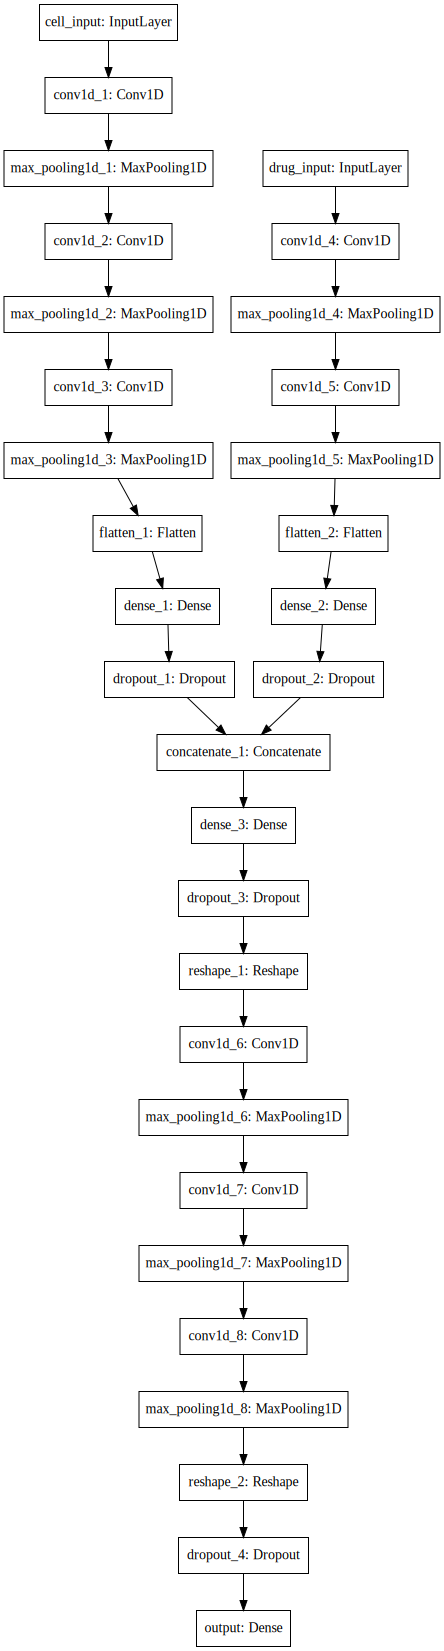

In [15]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

#### Model training
Feed the training data to the model and perform training. As the Conv1D layers need 3d objects as input, *np.at_least_3d()* is used to add an extra dimension to the input data matrix. Model checkpoint will automatically save the best model after 8 epoches. The complete training process is run on the server, so we did not show the detailed record here.

In [ ]:
batch_size = 256
nb_epoch = 250

# checkpoint
filepath="model/weights-epoch{epoch:02d}-loss{val_loss:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only=False, period=8)

history = model.fit([np.atleast_3d(X_train_cell), np.atleast_3d(X_train_drug)], y_train,
                    batch_size=batch_size, epochs=nb_epoch,
                    verbose=2, validation_split=0.1,
                    callbacks=[checkpoint])

model.save('model/DNN_model_with_mutation.h5')

### Model evaluation
The trained model will be loaded, and we will use testing set to test the model with mean squared error as the metric. We also need to divide test data matrix into two parts, mutation matrix and drug matrix, as the model have two input layers.

In [17]:
from keras.models import load_model

num_of_genomic_feature = 19392

X_test_cell = np.array(X_test.iloc[:, :num_of_genomic_feature])
X_test_drug = np.array(X_test.iloc[:, num_of_genomic_feature:])


model = load_model('model/DNN_model_with_mutation.h5')

score = model.evaluate([np.atleast_3d(X_test_cell), np.atleast_3d(X_test_drug)], y_test, verbose=2)
print('Test mean squared error: ', score[0])

Test mean squared error: 1.0844926040833298


We could see that our DNN model achieved a mean squared error of around 1.08 on the testing set containing 59518 samples, which is good. We could also draw some plots for further evaluation of the model. 

In [22]:
#y_pre = model.predict([np.atleast_3d(X_test_cell), np.atleast_3d(X_test_drug)])  # predicting IC50 values on testing data
y_pre = np.load('D:/SNP/downloaded_data/y_pre.npy')
len(y_pre)

59518

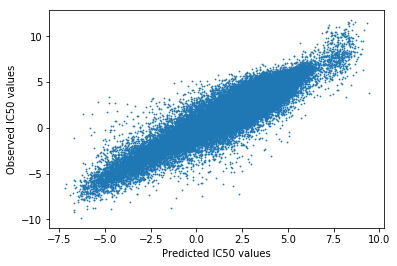

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline  

plt.figure()
plt.scatter(y_pre, y_test, s=0.6)
plt.xlabel('Predicted IC50 values')
plt.ylabel('Observed IC50 values')
plt.show()

In [34]:
import scipy.stats as stats
spearman = stats.stats.spearmanr(y_pre, y_test)
print('The Spearman correlation is ' + str(spearman.correlation))

The Spearman correlation is 0.899092223626
